Calculate distance to NDVI cells

In [13]:
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.transform import rowcol
from scipy.ndimage import distance_transform_edt
from shapely.geometry import Point
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Parameters
input_ndvi_tif = "D:/terrain_generation_project/NAIP_processed/naip_tiles_1_8_redo_3_ndvi.tif"  # "data/naip_tiles_1_8_redo_3_ndvi.tif" # GET THIS FROM GOOGLE DRIVE
structure_sf_poly = "data/clipped_structure_polygons_altadena/clipped_structure_polygons_altadena.shp"

structure_points_gpkg = "data/structures_with_neighbors.gpkg"
structure_points_layer = "structures_with_neighbors"

# Outputs
output_layer = "structures_with_distance_ndvi"
output_polygons_gpkg = "data/structures_ndvi_poly_min_and_mean.gpkg"
output_points_gpkg = "data/structures_ndvi_points_min_and_mean.gpkg"

ndvi_min = 0.3
ndvi_max = 0.8

In [ ]:
# Load NDVI and create vegetation mask
print("Loading NDVI raster...")
with rasterio.open(input_ndvi_tif) as src:
    ndvi = src.read(1)
    transform = src.transform
    crs = src.crs
    nodata = src.nodata

    # Handle nodata
    valid_mask = (ndvi != nodata) if nodata is not None else np.ones_like(ndvi, dtype=bool)

    # NDVI mask: vegetation pixels between thresholds
    veg_mask = (ndvi >= ndvi_min) & (ndvi <= ndvi_max) & valid_mask
    inverse_mask = ~veg_mask

    print("Computing distance transform...")
    distance_pixels = distance_transform_edt(inverse_mask)

    # Convert to meters
    pixel_size = transform.a
    distance_meters = distance_pixels * pixel_size

# Load structure polygons (Shapefile) and points (GeoPackage)
print("Loading structure polygons and points...")
structure_polys = gpd.read_file(structure_sf_poly).to_crs(crs)
structure_points = gpd.read_file(structure_points_gpkg, layer=structure_points_layer).to_crs(crs)

print(structure_points.head())

Loading NDVI raster...
Computing distance transform...
Loading structure polygons and points...
   OBJECTID                              GLOBALID            DAMAGE  \
0      9344  840cadc8-3d81-4bec-8950-0338ab901bf0         No Damage   
1      9676  0a60e2a2-d194-4638-852e-c523bed8862b  Destroyed (>50%)   
2     10340  d605598a-09e1-4fef-9fe2-20556ed3f796         No Damage   
3      3107  5b51db73-51f9-4627-b7b4-c3d8c599b379         No Damage   
4     11265  b2563acd-59f7-446b-88e7-a6e25feeaf33  Destroyed (>50%)   

                          STRUCTURETYPE  burned  total_neighbors_20m  \
0                Utility Misc Structure       0                    1   
1                Utility Misc Structure       1                    1   
2  Single Family Residence Single Story       0                    2   
3                Utility Misc Structure       0                    1   
4  Single Family Residence Single Story       1                    2   

   burned_neighbors_20m  burned_proportion_2

In [ ]:
# Spatial join: assign each point to a polygon
print("Joining points to polygons...")
joined = gpd.sjoin(structure_points, structure_polys, predicate="within", how="inner")

# Filter polygons to only those with matched points
structure_polys = structure_polys.loc[joined.index_right.unique()].copy()

# Prepare output columns
structure_polys["ndvi_min_dist_m"] = np.nan
structure_polys["ndvi_mean_dist_m"] = np.nan

# === Calculate distances from polygon boundaries ===
print("Calculating distances from polygons to vegetation (min and mean)...")
for idx, poly in tqdm(structure_polys.iterrows(), total=len(structure_polys), desc="Processing polygons"):
    try:
        boundary_coords = np.array(poly.geometry.boundary.coords)
        dists = []
        for x, y in boundary_coords:
            row, col = rowcol(transform, x, y)
            if (0 <= row < distance_meters.shape[0]) and (0 <= col < distance_meters.shape[1]):
                dists.append(distance_meters[row, col])

        if dists:
            structure_polys.at[idx, "ndvi_min_dist_m"] = np.min(dists)
            structure_polys.at[idx, "ndvi_mean_dist_m"] = np.mean(dists)
    except Exception:
        pass  # leave NaNs

# === Assign distances to points based on matched polygon ===
print("Assigning distances back to points...")
joined = joined.reset_index(drop=True)
joined = joined.merge(
    structure_polys[["ndvi_min_dist_m", "ndvi_mean_dist_m"]],
    left_on="index_right",
    right_index=True
)

print("Joined columns:", joined.columns.tolist())

Joining points to polygons...
Calculating distances from polygons to vegetation (min and mean)...


Processing polygons: 100%|██████████| 9231/9231 [00:05<00:00, 1765.17it/s]

Assigning distances back to points...
Joined columns: ['OBJECTID', 'GLOBALID', 'DAMAGE', 'STRUCTURETYPE', 'burned', 'total_neighbors_20m', 'burned_neighbors_20m', 'burned_proportion_20m_left', 'total_neighbors_50m', 'burned_neighbors_50m', 'burned_proportion_50m_left', 'total_neighbors_100m', 'burned_neighbors_100m', 'burned_proportion_100m_left', 'geometry', 'index_right', 'BUILD_ID', 'OCC_CLS', 'PRIM_OCC', 'SEC_OCC', 'PROP_ADDR', 'PROP_CITY', 'PROP_ST', 'PROP_ZIP', 'OUTBLDG', 'STATE_FIPS', 'FIPS', 'HEIGHT', 'SQMETERS', 'SQFEET', 'H_ADJ_ELEV', 'L_ADJ_ELEV', 'USNG', 'UUID', 'LONGITUDE', 'LATITUDE', 'B_CODE', 'POP_MEDIAN', 'POP_CI95_L', 'POP_CI95_U', 'CENSUSCODE', 'PROD_DATE', 'SOURCE', 'IMAGE_NAME', 'IMAGE_DATE', 'VAL_METHOD', 'REMARKS', 'Shape_Leng', 'Shape_Area', 'ndvi_min_dist_m_x', 'ndvi_mean_dist_m_x', 'burned_any', 'burned_ratio', 'burned_count', 'total_count', 'burned_proportion_20m_right', 'burned_proportion_50m_right', 'burned_proportion_100m_right', 'ndvi_min_dist_m_y', 'ndvi

In [36]:
joined = joined.rename(columns={
    "burned_proportion_20m_left": "burned_proportion_20m",
    "burned_proportion_50m_left": "burned_proportion_50m",
    "burned_proportion_100m_left": "burned_proportion_100m"
})

# Drop any old versions of these fields to prevent conflict
columns_to_drop = [
    'burned_any', 'burned_ratio', 'burned_count', 'total_count',
    'burned_proportion_20m', 'burned_proportion_50m', 'burned_proportion_100m',
    'burned_neighbors_20m', 'total_neighbors_20m',
    'burned_neighbors_50m', 'total_neighbors_50m',
    'burned_neighbors_100m', 'total_neighbors_100m'
]
structure_polys = structure_polys.drop(columns=[c for c in columns_to_drop if c in structure_polys.columns])

# === Calculate polygon-level burn statistics ===
print("Calculating polygon burn statistics...")
burn_stats = (
    joined.groupby("index_right").agg(
        burned_any=("burned", lambda x: int(x.sum() > 0)),
        burned_ratio=("burned", "mean"),
        burned_count=("burned", "sum"),
        total_count=("burned", "count"),
        burned_proportion_20m=("burned_proportion_20m", "mean"),
        burned_proportion_50m=("burned_proportion_50m", "mean"),
        burned_proportion_100m=("burned_proportion_100m", "mean"),
        burned_neighbors_20m=("burned_neighbors_20m", "sum"),
        total_neighbors_20m=("total_neighbors_20m", "sum"),
        burned_neighbors_50m=("burned_neighbors_50m", "sum"),
        total_neighbors_50m=("total_neighbors_50m", "sum"),
        burned_neighbors_100m=("burned_neighbors_100m", "sum"),
        total_neighbors_100m=("total_neighbors_100m", "sum")
    )
)

# Add stats to polygon GeoDataFrame
structure_polys = structure_polys.join(burn_stats)

# === Save to separate GeoPackages ===
print(f"Saving polygon output to: {output_polygons_gpkg} (layer: polygons)...")
structure_polys.to_file(output_polygons_gpkg, layer="polygons", driver="GPKG")

print(f"Saving point output to: {output_points_gpkg} (layer: points)...")
joined.to_file(output_points_gpkg, layer="points", driver="GPKG")

print("Done.")

Calculating polygon burn statistics...
Saving polygon output to: data/structures_ndvi_poly_min_and_mean.gpkg (layer: polygons)...
Saving point output to: data/structures_ndvi_points_min_and_mean.gpkg (layer: points)...
Done.


In [30]:
avg_ndvi_mean_dist = structure_polys["burned_proportion_20m"].mean(skipna=True)
print(f"Average ratio of burned structures within 20m: {avg_ndvi_mean_dist:.2f}")

Average ratio of burned structures within 20m: 0.43


In [31]:
avg_ndvi_mean_dist = structure_polys["burned_proportion_50m"].mean(skipna=True)
print(f"Average ratio of burned structures within 50m: {avg_ndvi_mean_dist:.2f}")

Average ratio of burned structures within 50m: 0.70


In [21]:
avg_ndvi_mean_dist = structure_polys["ndvi_mean_dist_m"].mean(skipna=True)
print(f"Average NDVI mean distance (m): {avg_ndvi_mean_dist:.2f}")

Average NDVI mean distance (m): 2.94


In [22]:
avg_ndvi_mean_dist = structure_polys["ndvi_min_dist_m"].mean(skipna=True)
print(f"Average NDVI min distance (m): {avg_ndvi_mean_dist:.2f}")

Average NDVI min distance (m): 0.70


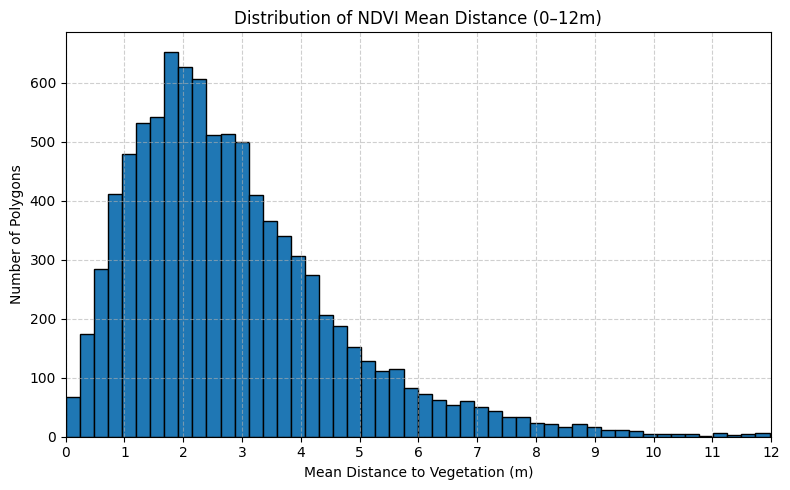

In [ ]:
# Filter distances to values less than or equal to 12 meters
filtered = structure_polys["ndvi_mean_dist_m"]
filtered = filtered[filtered <= 12]

# Plot histogram with finer bins and custom x-axis ticks
plt.figure(figsize=(8, 5))
plt.hist(filtered, bins=50, edgecolor='black')
plt.xlabel("Mean Distance to Vegetation (m)")
plt.ylabel("Number of Polygons")
plt.title("Distribution of NDVI Mean Distance (0–12m)")
plt.xlim(0, 12)
plt.xticks(np.arange(0, 13, 1))  # Tick marks at each whole number
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

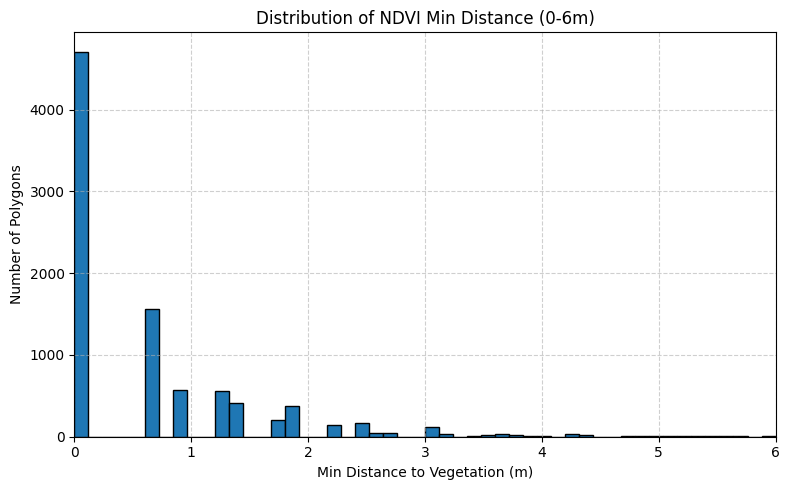

In [27]:
# Filter distances to values less than or equal to 12 meters
filtered = structure_polys["ndvi_min_dist_m"]
filtered = filtered[filtered <= 6]

# Plot histogram with finer bins and custom x-axis ticks
plt.figure(figsize=(8, 5))
plt.hist(filtered, bins=50, edgecolor='black')
plt.xlabel("Min Distance to Vegetation (m)")
plt.ylabel("Number of Polygons")
plt.title("Distribution of NDVI Min Distance (0-6m)")
plt.xlim(0, 6)
plt.xticks(np.arange(0, 7, 1))  # Tick marks at each whole number
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()